
==================== BOSTON LOGAN INTERNATIONAL AIRPORT, MA US ====================
Best → hidden=(64,), alpha=0.01, lr=0.0001, MAE=7.2285


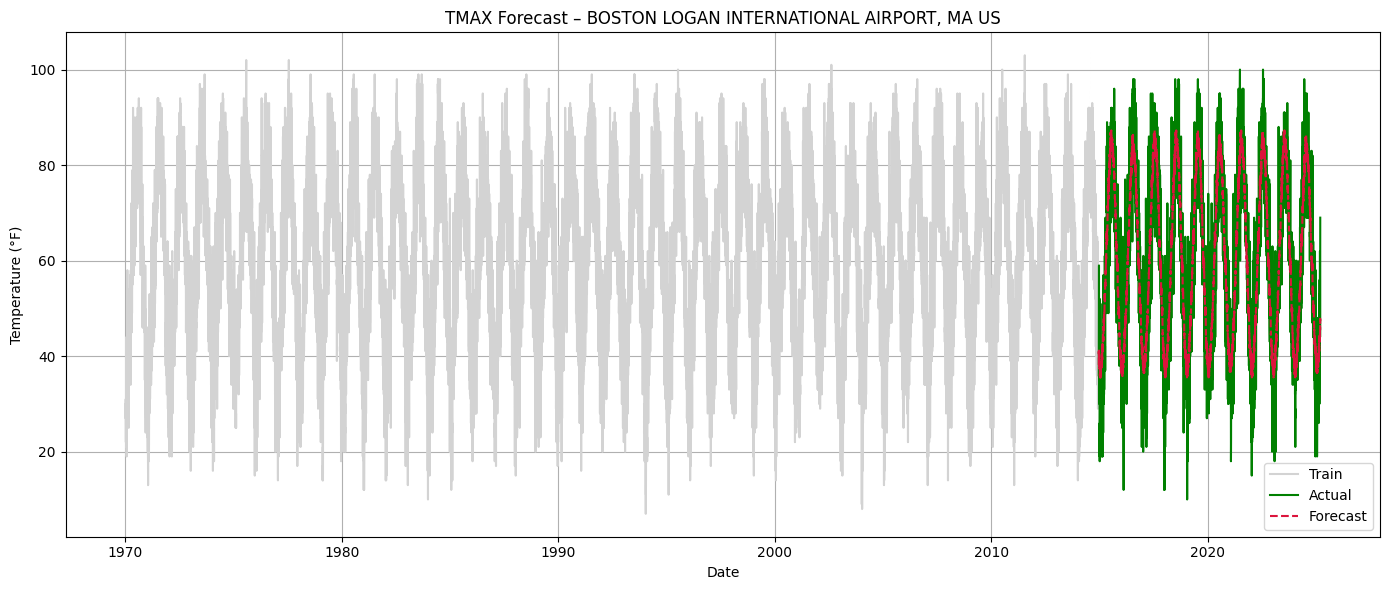


==================== BUENOS AIRES OBSERV, AR ====================
Best → hidden=(64,), alpha=0.01, lr=0.0001, MAE=5.3350


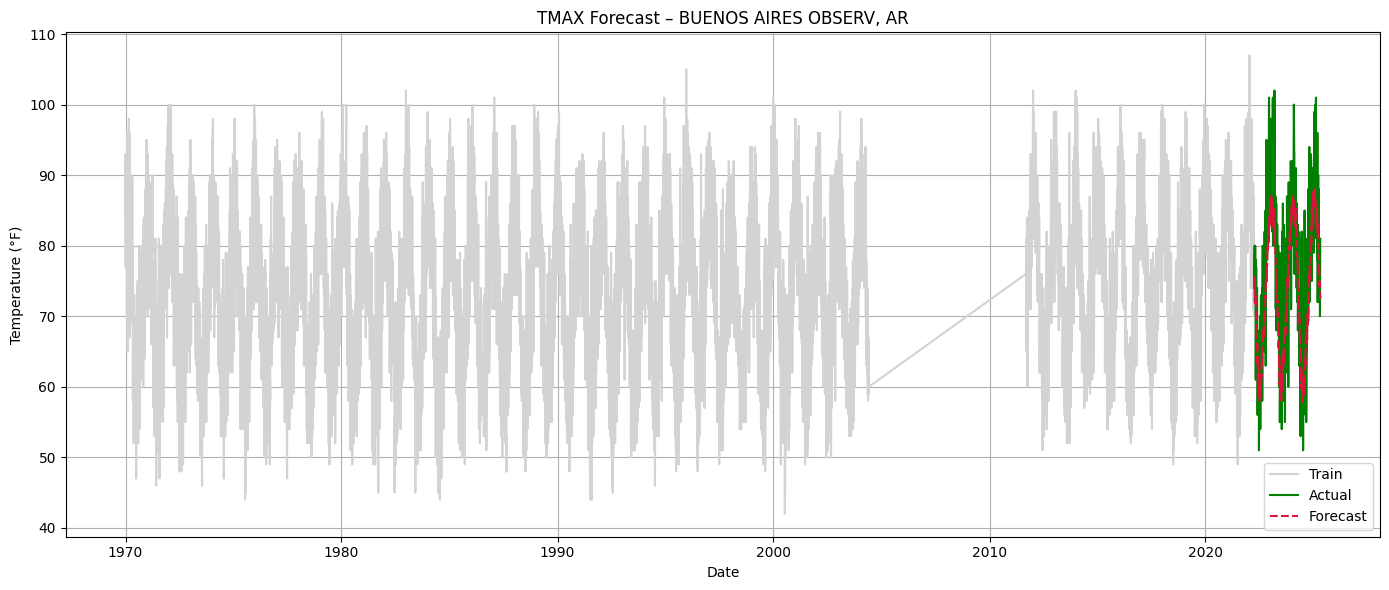


==================== DARWIN AIRPORT, AS ====================
Best → hidden=(128, 64), alpha=0.01, lr=0.001, MAE=2.3335


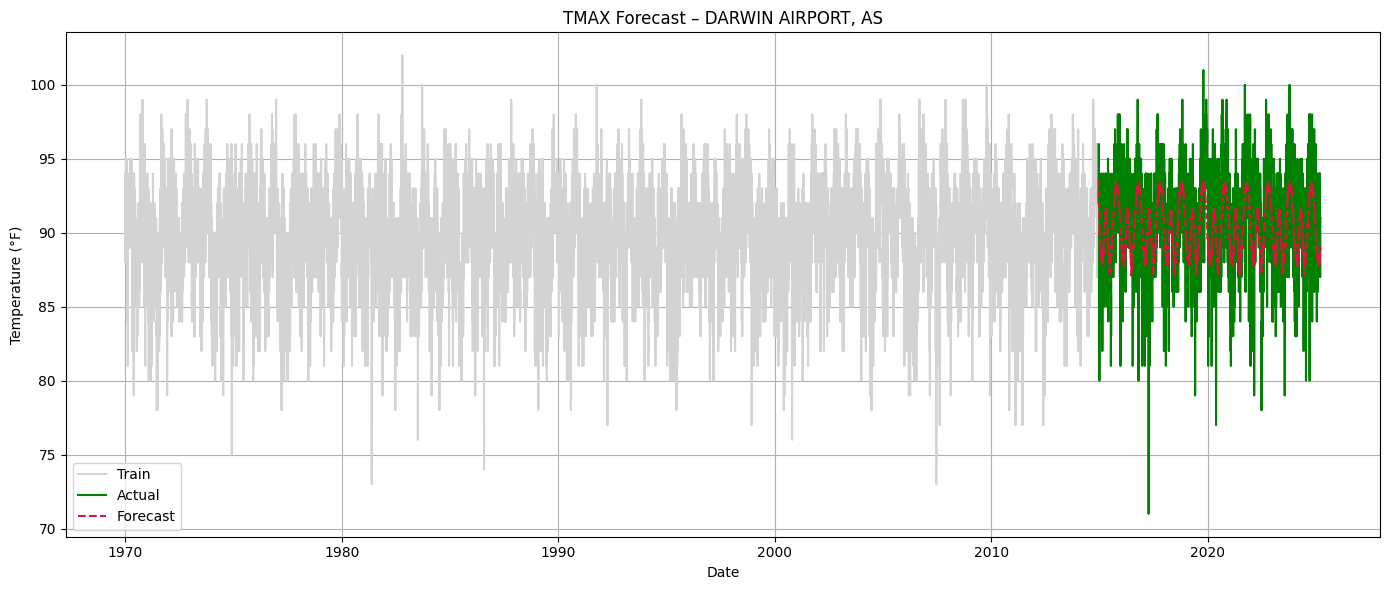


==================== JFK INTERNATIONAL AIRPORT, NY US ====================
Best → hidden=(128, 64), alpha=0.01, lr=0.0001, MAE=5.9301


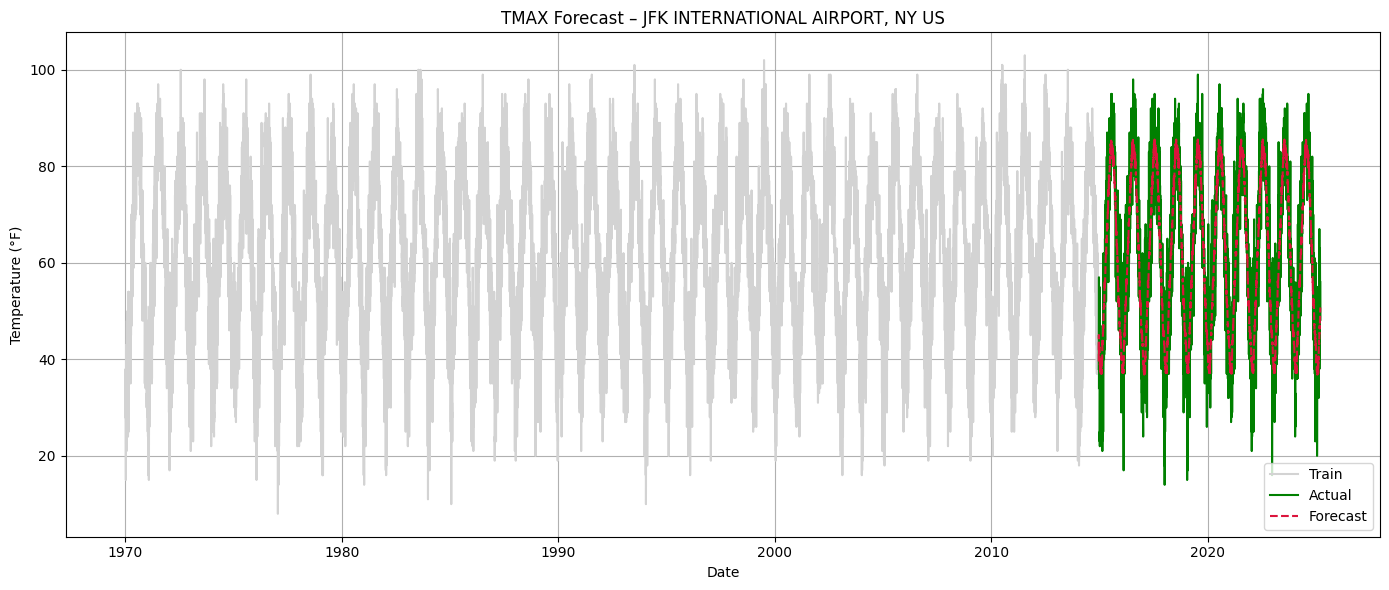


==================== MADRID CUATROVIENTOS, SP ====================
Best → hidden=(128, 64), alpha=0.01, lr=0.0001, MAE=5.8432


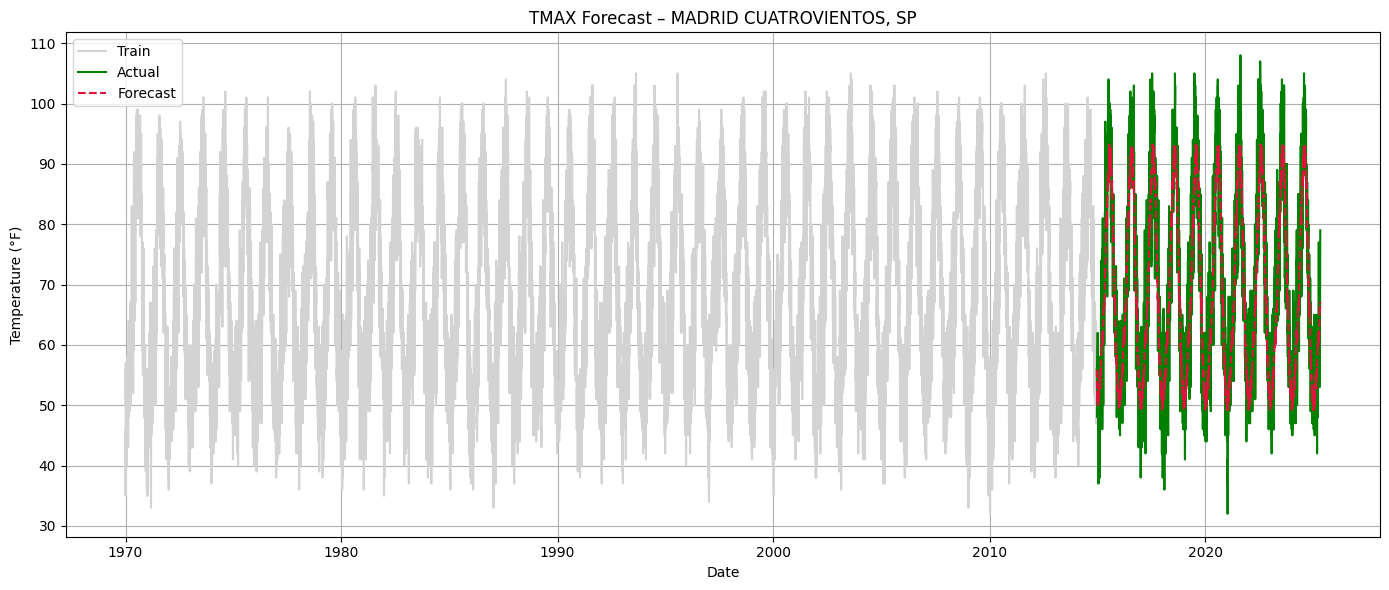


==================== VLADIVOSTOK, RS ====================
Best → hidden=(128, 64), alpha=0.01, lr=0.0001, MAE=6.6314


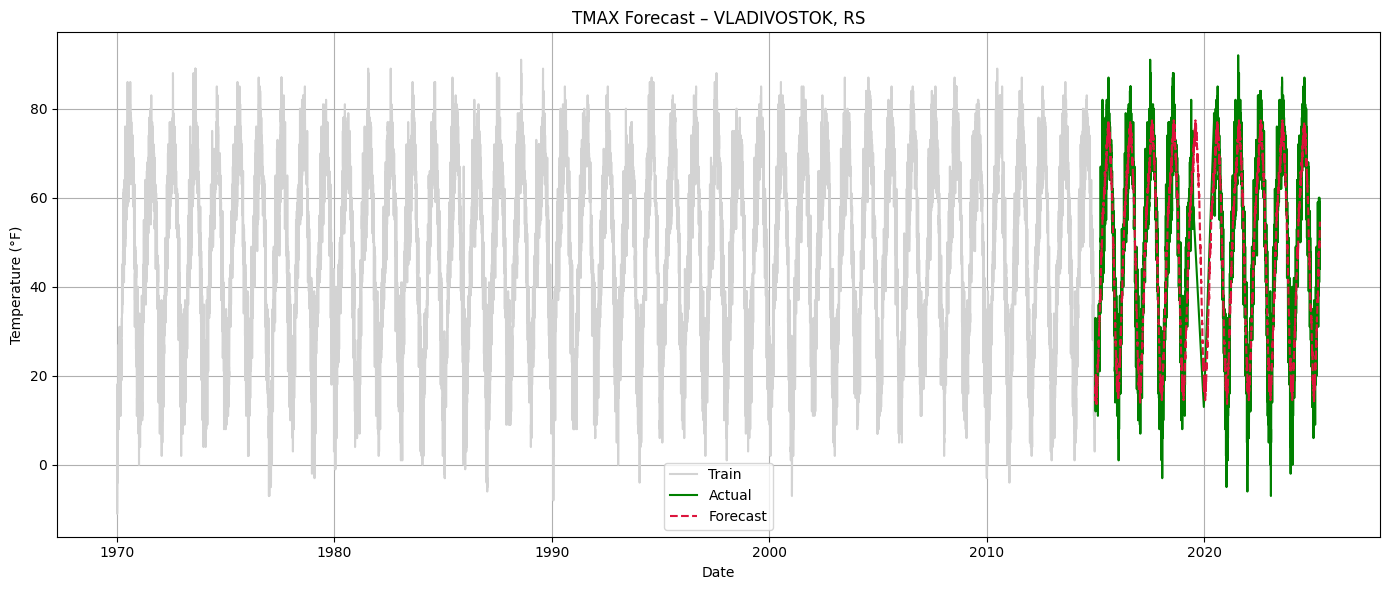

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

# ── Config ─────────────────────────────────────────────
SAMPLE_FACTOR = 1
TEST_YEARS    = 11
TRAIN_YEARS   = 45
RESPONSE_VAR  = "TMAX"
LOOKBACK      = 30

# ── Load & Preprocess ─────────────────────────────────
df_all = pd.read_csv("cities_final.csv", parse_dates=["DATE"])
df_all["PRCP"] = 0  # dummy column if PRCP doesn't exist
df_all["PRCP"].fillna(0, inplace=True)
df_all.interpolate(method="linear", inplace=True)

# ── For Each City by NAME ─────────────────────────────
for name, df in df_all.groupby("NAME"):
    print(f"\n{'='*20} {name} {'='*20}")
    df = df.sort_values("DATE").copy()
    df.set_index("DATE", inplace=True)

    # ── Feature Engineering ────────────────
    df["month"]       = df.index.month
    df["day_of_year"] = df.index.dayofyear
    df["sin_month"]   = np.sin(2*np.pi * df["month"]/12)
    df["cos_month"]   = np.cos(2*np.pi * df["month"]/12)
    df["sin_day"]     = np.sin(2*np.pi * df["day_of_year"]/365)
    df["cos_day"]     = np.cos(2*np.pi * df["day_of_year"]/365)

    sampled = df.iloc[::SAMPLE_FACTOR]
    n_train = int(TRAIN_YEARS * 365 / SAMPLE_FACTOR)
    n_test  = int(TEST_YEARS  * 365 / SAMPLE_FACTOR)
    train_df = sampled.iloc[:n_train]
    test_df  = sampled.iloc[n_train:n_train + n_test]

    date_feats   = ["sin_month","cos_month","sin_day","cos_day"]
    feature_cols = [RESPONSE_VAR] + date_feats

    scaler     = MinMaxScaler()
    train_vals = scaler.fit_transform(train_df[feature_cols])
    test_vals  = scaler.transform(test_df[feature_cols])
    test_date_feats = test_vals[:, 1:]

    def build_sequences(values, lookback):
        X, y = [], []
        for i in range(len(values) - lookback):
            X.append(values[i : i+lookback].flatten())
            y.append(values[i+lookback, 0])
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_vals, LOOKBACK)

    # ── Small Grid Search ──────────────────
    param_grid = {
        "hidden_layer_sizes": [(128, 64), (64,)],
        "alpha": [1e-3, 1e-2],
        "learning_rate_init": [1e-3, 1e-4],
    }

    results = []
    for hidden in param_grid["hidden_layer_sizes"]:
        for alpha in param_grid["alpha"]:
            for lr in param_grid["learning_rate_init"]:
                mdl = MLPRegressor(
                    hidden_layer_sizes=hidden,
                    activation="relu",
                    solver="adam",
                    alpha=alpha,
                    learning_rate_init=lr,
                    max_iter=1000,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=20,
                    random_state=42
                )
                mdl.fit(X_train, y_train)

                last_window = train_vals[-LOOKBACK:].copy()
                preds_scaled = []
                for i in range(len(test_df)):
                    inp = last_window.flatten().reshape(1, -1)
                    p   = mdl.predict(inp)[0]
                    preds_scaled.append(p)
                    nxt = np.concatenate([[p], test_date_feats[i]])
                    last_window = np.vstack([last_window[1:], nxt])

                full_pred_scaled = np.hstack([
                    np.array(preds_scaled).reshape(-1,1),
                    test_date_feats
                ])
                full_pred = scaler.inverse_transform(full_pred_scaled)
                preds = full_pred[:, 0]
                mae = mean_absolute_error(test_df[RESPONSE_VAR], preds)
                results.append({"hidden": hidden, "alpha": alpha, "lr": lr, "mae": mae})

    best = min(results, key=lambda x: x["mae"])
    print(f"Best → hidden={best['hidden']}, alpha={best['alpha']}, lr={best['lr']}, MAE={best['mae']:.4f}")

    # ── Retrain with Best Params ───────────
    final_model = MLPRegressor(
        hidden_layer_sizes=best["hidden"],
        activation="relu",
        solver="adam",
        alpha=best["alpha"],
        learning_rate_init=best["lr"],
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42
    )
    final_model.fit(X_train, y_train)

    # ── Final Forecast ─────────────────────
    last_window = train_vals[-LOOKBACK:].copy()
    preds_scaled = []
    for i in range(len(test_df)):
        inp = last_window.flatten().reshape(1, -1)
        p   = final_model.predict(inp)[0]
        preds_scaled.append(p)
        nxt = np.concatenate([[p], test_date_feats[i]])
        last_window = np.vstack([last_window[1:], nxt])

    full_pred_scaled = np.hstack([
        np.array(preds_scaled).reshape(-1,1),
        test_date_feats
    ])
    full_pred = scaler.inverse_transform(full_pred_scaled)
    preds = full_pred[:, 0]
    pred_series = pd.Series(preds, index=test_df.index)

    # ── Plot ───────────────────────────────
    plt.figure(figsize=(14, 6))
    plt.plot(train_df[RESPONSE_VAR], color="lightgray", label="Train")
    plt.plot(test_df[RESPONSE_VAR],  color="green",     label="Actual")
    plt.plot(pred_series,             color="crimson",   linestyle="--", label="Forecast")
    plt.title(f"{RESPONSE_VAR} Forecast – {name}")
    plt.xlabel("Date"); plt.ylabel("Temperature (°F)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()
